# Coursework Support

<br>

### Imports

In [4]:
library(RNetCDF)
library(tidync)
library(ncmeta)
library(tidyverse)
library(lubridate)
library(ggplot2)

<br>

### Loading Data

We'll begin by loading the NetCDF file using `tidync`. When we do so we retrieve both the values of the data-array it contains as well as the metadata that describes it. 

In [2]:
nc_filepath = '../data/Coursework-Support/era5.nc'

nc_file = tidync(nc_filepath)

nc_file


Data Source (1): era5.nc ...

Grids (4) <dimension family> : <associated variables> 

[1]   D0,D1,D2 : u10, v10, ssrd    **ACTIVE GRID** ( 745488  values per variable)
[2]   D0       : longitude
[3]   D1       : latitude
[4]   D2       : time

Dimensions 3 (all active): 
  
  dim   name   length      min    max start count    dmin   dmax unlim coord_dim 
  <chr> <chr>   <dbl>    <dbl>  <dbl> <int> <int>   <dbl>  <dbl> <lgl> <lgl>     
1 D0    longi~    501       90 1.40e2     1   501  9.00e1 1.40e2 FALSE TRUE      
2 D1    latit~    186      -12 6.50e0     1   186 -1.20e1 6.50e0 FALSE TRUE      
3 D2    time        8  1043144 1.05e6     1     8  1.04e6 1.05e6 FALSE TRUE      

<br>

We can see that there are 3 dimemensions in the file, calling `hyper_dims` lets us inspect them in more detail.

We can see that longitude, latitude and time are not 'unlimited', this means that the extent of the data is fixed. 'coord_dim' as True denotes that the dimension is being used is attached to the dataset, in this case they all are but think about examples where this maybe different (e.g. providing multiple versions of coordinates for different CRS').

In [3]:
hyper_dims(nc_file)

name,length,start,count,id,unlim,coord_dim
longitude,501,1,501,0,FALSE,TRUE
latitude,186,1,186,1,FALSE,TRUE
time,8,1,8,2,FALSE,TRUE


<br>

We can see that there are 4 grids and that 3 of them are the dimensions we just explored, what's left over? - the variables. 

Here we can see that there are 3 variables, two for the u and v components of a wind vector, the other for surface solar radiation. From these we estimate solar and wind power production at different locations in Indonesia.

In [32]:
hyper_vars(nc_file)

id,name,type,ndims,natts,dim_coord
3,u10,NC_SHORT,3,6,FALSE
4,v10,NC_SHORT,3,6,FALSE
5,ssrd,NC_SHORT,3,7,FALSE


<br>

This is all very useful but what about if we wanted to store additional, more general metadata about the dataset?

Luckily NetCDFs allow us to store further information as 'attributes' to both the top-level of the file as well as for individual variables. By specifying `'NC_GLOBAL'` as the variable we can list only the attributes for the top-level of the file, this includes information such as when the file was downloaded.

In [36]:
ncmeta::nc_atts(nc_filepath, 'NC_GLOBAL')

id,name,variable,value
0,Conventions,NC_GLOBAL,CF-1.6
1,history,NC_GLOBAL,2020-12-10 14:47:04 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data0/adaptor.mars.internal-1607611614.7236085-5982-17-ac6b25d3-2c5a-4a80-8c51-bece0fdfbc32.nc /cache/tmp/ac6b25d3-2c5a-4a80-8c51-bece0fdfbc32-adaptor.mars.internal-1607611614.7241852-5982-5-tmp.grib


<br>

To access the attributes for a specific variable we just pass that variable's name to `nc_atts`. Doing this for `'u10'` provides us information such as the units and the value for missing values. 

The `scale_factor` and `add_offset` enable intelligent methods for compressing data, these are automatically applied to the data on loading and saving to redue the size of the stored data, you can find out more [here](https://www.unidata.ucar.edu/software/netcdf/workshops/2010/bestpractices/Packing.html).

In [37]:
ncmeta::nc_atts(nc_filepath, 'u10')

id,name,variable,value
0,scale_factor,u10,0.0003157431
1,add_offset,u10,1.074366
2,_FillValue,u10,-32767
3,missing_value,u10,-32767
4,units,u10,m s**-1
5,long_name,u10,10 metre U wind component


<br>

Let's dig a little deeper into the dimensions we have, what does 'time' look like? 

Before we can access the values we need to activate the correct grid, which currently is the one containing 'u10', 'v10', and 'ssrd'. We'll switch over to 'time' by activating it, then extract the values by calling `hyper_tibble`.

In [71]:
times <- (nc_file %>% activate(time) %>% hyper_tibble)$time

times

[1] 1043144 1043148 1043152 1043156 1047488 1047492 1047496 1047500

<br>

Hmm these don't like like any dates we're used to working with, what's going on?

Let's inspect the attributes of the time variable to find out more.

In [51]:
ncmeta::nc_atts(nc_filepath, 'time')

id,name,variable,value
0,units,time,hours since 1900-01-01 00:00:00.0
1,long_name,time,time
2,calendar,time,gregorian


<br>

Lets create a function that maps from the time dimension to the relevant date string.

We can now see that we have data for 4 different hours of the day, from two separate days in the year.

In [69]:
hours_to_datetime <- function(hour) {
    start_date <- ymd('1900-01-01')
    datetime <- start_date + dhours(hour)
    return(datetime)
}

datetime <- hours_to_datetime(times)

datetime

[1] "2019-01-01 08:00:00 UTC" "2019-01-01 12:00:00 UTC"
[3] "2019-01-01 16:00:00 UTC" "2019-01-01 20:00:00 UTC"
[5] "2019-07-01 08:00:00 UTC" "2019-07-01 12:00:00 UTC"
[7] "2019-07-01 16:00:00 UTC" "2019-07-01 20:00:00 UTC"

<br>

Now we'll start looking at the actual data, to make things easier lets take a slice of it, filtering for only the first hour we have data for. To do this we can use the `hyper_filter` function which will filter over multiple dimensions if passed. We also have to make sure to reactivate the relevant data grid, in this case the solar radiation, using `activate`. Finally we convert the tinync object into a hyper-array using `hyper_array`.

In [142]:
radiation_slice <- nc_file %>% 
                    activate(ssrd) %>% 
                    hyper_filter(time=time<1043145) %>% 
                    hyper_array

radiation_slice

Class: tidync_data (list of tidync data arrays)
Variables (1): 'ssrd'
Dimension (2): longitude,latitude,time (501, 186)
Source: C:/Users/Spatial/Downloads/ESDA-Spatial-master/ESDA-Spatial-master/tutorials/era5.nc

<br>

We're now in a position where we can start visualising the data!

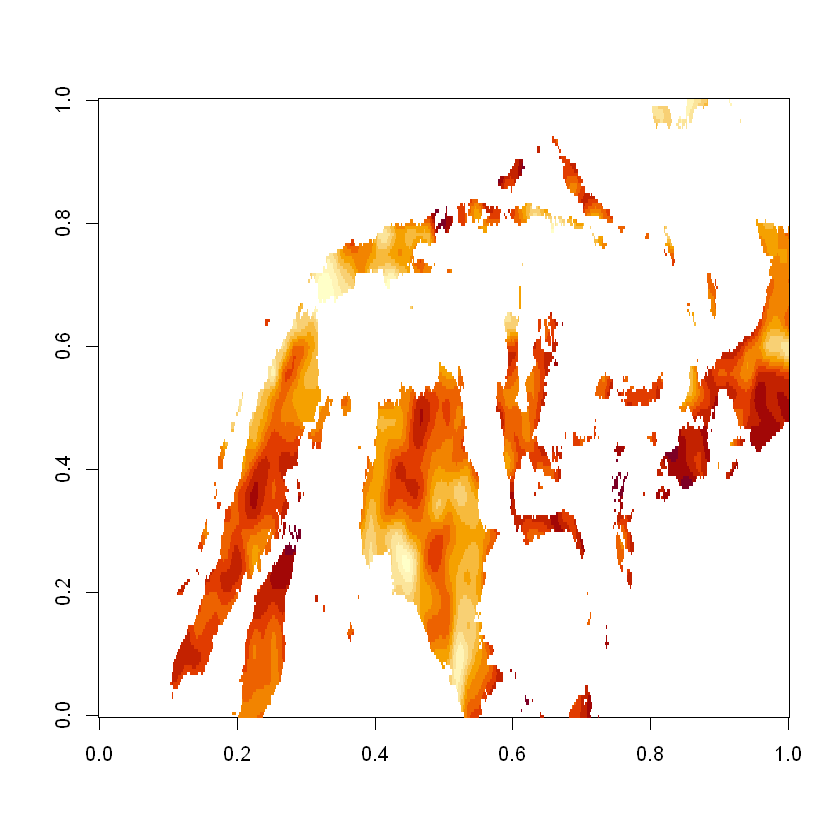

In [152]:
image(radiation_slice[[1]], useRaster=TRUE)

<br>

Unfortunately the plot isn't particularly helpful as its both oriented incorrectly and the x/y ratio is wrong.

Digging a little deeper we can see that the latitude values descend (from a higher to lower value) as expected, it is the image function that reverses them.

In [162]:
longitudes = (nc_file %>% activate(longitude) %>% hyper_tibble)$longitude
latitudes = (nc_file %>% activate(latitude) %>% hyper_tibble)$latitude

latitudes[1:5]

[1] 6.5 6.4 6.3 6.2 6.1

<br>

We'll create a new variable where we flip the data matrix in the y direction.

We'll also add a value for `asp` which is an abbreviation of aspect ratio, if we provide the lat/lon ratio we can achieve a more realistic visualisation.

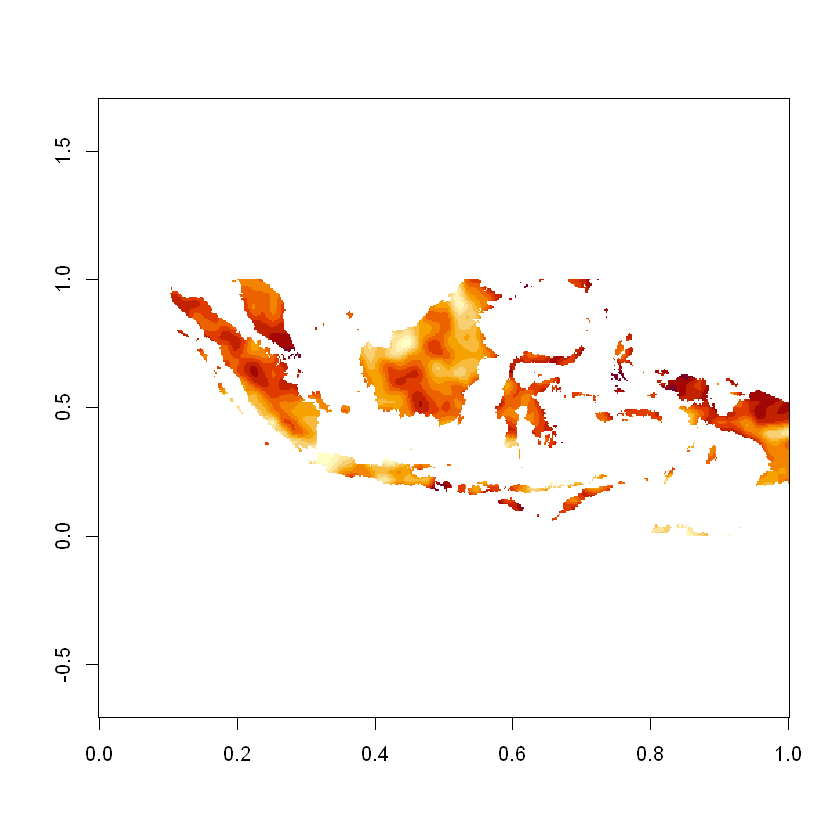

In [175]:
# We'll reverse the matrix
radiation_matrix <- radiation_slice[[1]]
radiation_matrix <- radiation_matrix[,length(latitudes):1]

# And also the latitudes values
latitudes = (nc_file %>% activate(latitude) %>% hyper_tibble)$latitude
latitudes <- latitudes[length(latitudes):1]

# Calculate the lat/lon ratio
lat_lon_ratio = length(latitudes)/length(longitudes)

# And visualise them
image(radiation_matrix, asp=lat_lon_ratio)

<br>

Let's identify the coordinates of the maximum value

In [208]:
max_rad <- max(radiation_matrix, na.rm=TRUE)
max_rad_idx <- which(radiation_matrix == max_rad, arr.ind=TRUE)

max_rad_idx

row,col
378,113


<br>

We can also convert them into longitude and latitude, from this we can determine that at this specific time the maximum solar radiation falling on indonesia was on the island of Bacan.

In [209]:
max_lon <- longitudes[max_rad_idx[1]]
max_lat <- latitudes[max_rad_idx[2]]

print(c(max_lon, max_lat))

[1] 127.7  -0.8


<br>

#### Questions

Identify the location with the lowest solar radiation

In [ ]:
# 

<br>

### Solar Radiation to Power Conversion

Let's convert from solar radiation to solar power, we'll use the standard conversion equation (further details in [Filik et al](https://www.e3s-conferences.org/articles/e3sconf/pdf/2017/10/e3sconf_asee2017_00046.pdf)).

$$E(t) = A.r(t).g(t).p(t)$$

* $A$: Total solar panel area in $m^{2}$
* $r$: Panel efficiency (yield) parameter
* $G$: Solar radiation on tilted panels
* $p$: Performance ratio of the overall system

We'll base our calculations on a 10 $m^{2}$ solar panel with 17.5% efficiency and a performace ratio of 60%. 

Inspecting the attributes of the solar radiation grid tells us the units are in joules per $m^{2}$, assuming that the solar radiation stays constant for the entire hour we can view the units in terms of watt-hours which will make calculations easier.

In [223]:
ncmeta::nc_atts(nc_filepath, 'ssrd')

id,name,variable,value
0,scale_factor,ssrd,336.1979
1,add_offset,ssrd,12895679
2,_FillValue,ssrd,-32767
3,missing_value,ssrd,-32767
4,units,ssrd,J m**-2
5,long_name,ssrd,Surface solar radiation downwards
6,standard_name,ssrd,surface_downwelling_shortwave_flux_in_air


<br>

We'll create a conversion function that calculates the kWh output for a theoretical solar panel, in this case using data from between 8 and 9 AM at the location with highest solar radiation.

In [212]:
radiation_to_power <- function(radiation, area=10, yield=0.175, pr=0.6, hours=1){
    kWh <- radiation * area * yield * pr * (hours/3600) / 1000
    return(kWh)
}

max_kWh <- radiation_to_power(max_rad)

max_kWh

[1] 6.022157

<br>

#### Questions

Calculate the difference between this and the location with lowest solar radiation

In [ ]:
# 

<br>

### Wind Speed to Power Conversion

Wind vectors are a useful way to communicate speed and direction, in particular they allow both direction to be expressed in terms of a cyclical variable (unlike degrees which has a discontinuity) - this is often a more useful feature for ML models. However in vector form we cant convert to power output, for that we'll have to calculate the wind speed as an intermediate.

To calculate u and v from wind speed and direction we can use:
* $u = speed \times cos(direction)$
* $v = speed \times sin(direction)$

To convert back to wind speed we can use:
* $speed = \sqrt{u^{2}+v^{2}}$

<br>

We'll calculate wind speed and then visualise it

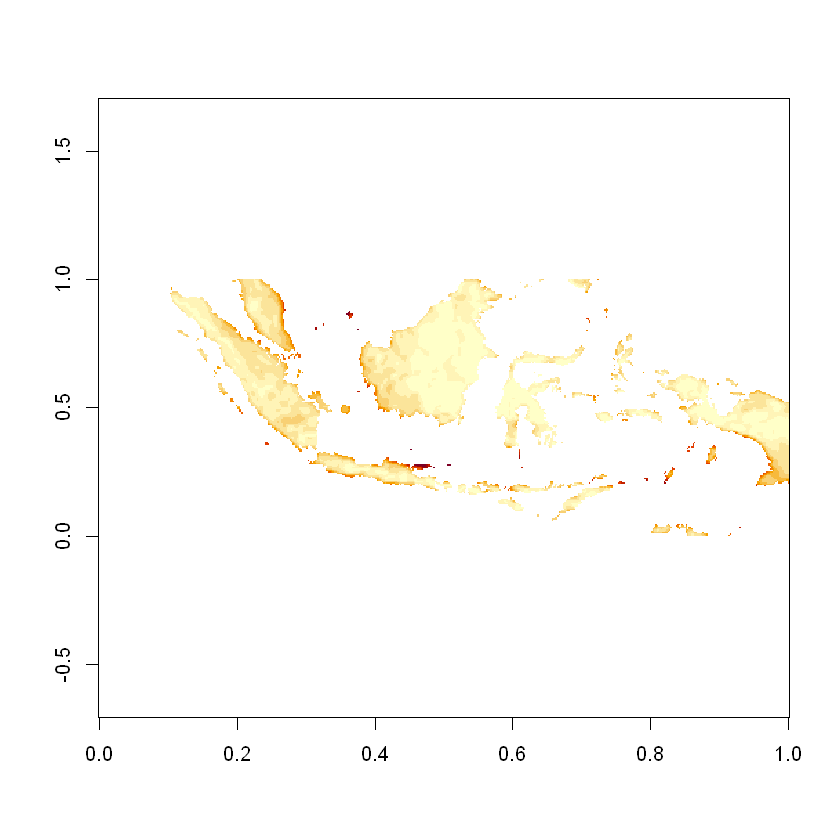

In [229]:
u_slice <- nc_file %>% 
            activate(u10) %>% 
            hyper_filter(time=time<1043145) %>% 
            hyper_array

v_slice <- nc_file %>% 
            activate(v10) %>% 
            hyper_filter(time=time<1043145) %>% 
            hyper_array

u_matrix <- u_slice[[1]]
v_matrix <- v_slice[[1]]

speed_matrix <- sqrt(u_matrix**2 + v_matrix**2)
speed_matrix <- speed_matrix[,length(latitudes):1]

image(speed_matrix, asp=lat_lon_ratio)

<br>

Again we'll use the maximum value of the resource as an example

In [230]:
max_speed <- max(speed_matrix, na.rm=TRUE)

max_speed

[1] 11.75392

<br>

We'll use the Helman equation to extrapolate from 10m up to 70m which is a more common height for wind turbines, to do this we'll use an estimated value for the hellman exponent - 1/7. Helman Equation:

<b>speed at turbine = data speed x (turbine height/data height)^hellman exponent</b>

If you are able to obtain surface roughness data for indonesia you can calculate a more accurate helman exponent using:  

<b>hellman exponent = 1 / ln(turbine height/roughness)</b>

In [232]:
calc_turbine_speed <- function(speed, turbine_height=70, data_height=10, hellman_exponent=1/7){
    turbine_speed <-  speed*(turbine_height/data_height)^hellman_exponent
    return(turbine_speed)
}

turbine_speed <- calc_turbine_speed(max_speed)

turbine_speed

[1] 15.52069

<br>

We now need to convert the wind speed into wind power, to do so we can use a power curve. In this example we'll use the power curve of the Gamsea G114, the turbine used in the Indonesian Sidrap wind farm. The data used for this can be found [here](https://www.thewindpower.net/turbine_en_599_gamesa_g114-2500.php).

In [262]:
speed_to_power <- function(speed){
    pc <- c(0, 0, 0, 0, 0, 40, 102, 160, 257, 355, 471, 605, 750, 972, 1194, 1455, 1713, 1970, 2227, 2380, 2465, 2495, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2460, 2400, 2335, 2250)
    names(pc) <- seq(from=0, to=24, by=0.5)
    power <- pc[toString(round(speed, 0))]
    return(power)
}

power <- speed_to_power(turbine_speed)

power

16 
2500

<br>

#### Questions

Now try and calculate another layer that shows wind direction, how could this be useful in your analysis?
For additional reading please look [here](http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv). You should also try to calculate power output for an offshore wind farm using a power curve of an offshore turbine.

In [ ]:
# 

<br>

### Financial Modelling

Now that we can calcuate the power output for solar and wind farms we'll do some financial modelling with them.

First we'll calculate the annual revenue of the wind farm, we'll use the number of turbines and capacity from the Sidrap wind farm. We'll assume a capacity factor of 30%, lifetime of 25 years and electricity price of $0.07/kWh.

In [298]:
turbine_capacity <- 2.5
num_turbines <- 30
capacity_factor <- 0.3
dollars_per_kWh <- 0.07
lifetime_yrs <- 25

kWh <- turbine_capacity * num_turbines * capacity_factor * 1000 * 24 * 365
annual_revenue <-dollars_per_kWh  * kWh

annual_revenue

[1] 13797000

<br>

We can then use this to calcute the Net Present Value (NPV).

Here we'll assume the Sidrap capital expenditure (CAPEX) of 150,000,000. We'll assume an operating cost of 0 although in reality this would cost something. We'll assume a discount rate of 5%.

In [299]:
calc_NPV <- function(annual_revenue, i=0.05, lifetime_yrs=25, CAPEX=150000000, OPEX=0){
    costs <- rep(OPEX, lifetime_yrs)
    costs[1] <- costs[1]  + CAPEX
    revenue <- rep(annual_revenue, lifetime_yrs)

    t <- seq(1, lifetime_yrs, 1)
    NPV <- sum((revenue - costs)/(1 + i)**t)

    return(round(NPV, 0))
}

calc_NPV(annual_revenue)

[1] 51597010

<br>

#### Questions

Using the assumptions provided in the coursework instructions you should try to estimate the net present value of an ammonia plant. Assume a lifetime of 25 years.

In [ ]:
# 